# Data Analysis

For our models, we are going to be analyzing layoff data alongside information
about both the US's foreign aid spending per year and US GDP data.

### Methodology:

Our hypothesis is that given data about a company in conjunction with it's recent stock performance, we can predict the likelihood of a layoff. We will be using a variety of models to test this hypothesis.

## Retrieve STOCK DATA

In [6]:
# for data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[*********************100%%**********************]  1 of 1 completed


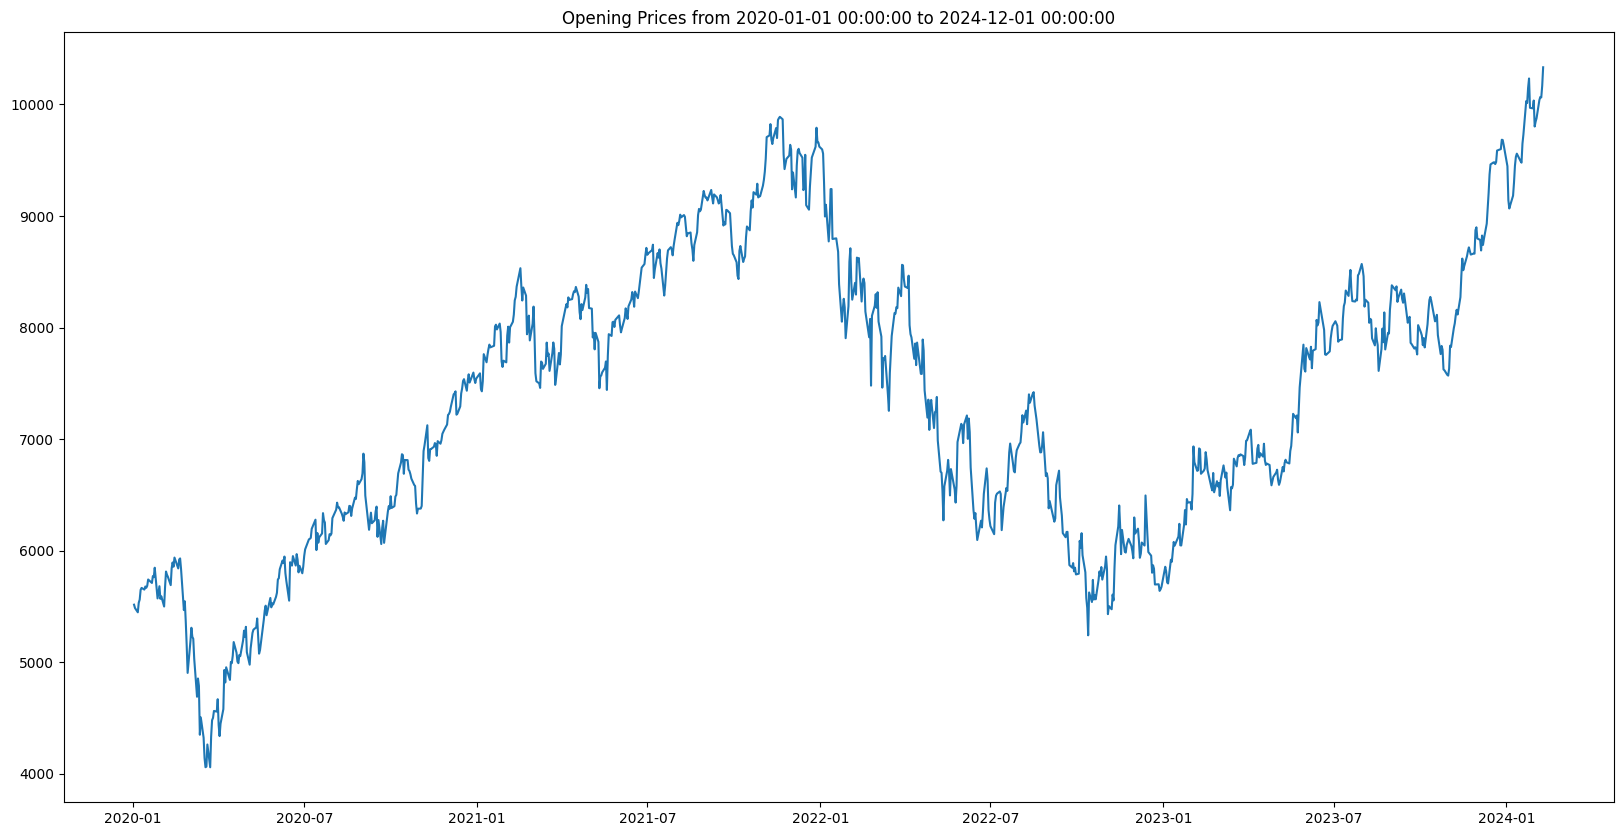

In [7]:
# TODO: weekly price diff (%) parsing from NDXT (NASDAQ 100 Tech companies index); add into data_pd as a new column

# for stock price retrieval
from datetime import datetime, timedelta
import yfinance as yf

# initialize parameters 
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 1)

# get the data 
stock_data = yf.download('^NDXT', start = start_date,
                         end = end_date)

stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8') # False: not include index

# display 
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(stock_data['Open'])
plt.show()

In [8]:
!pip install -r requirements.txt

zsh:1: command not found: pip


In [9]:
def date_to_index(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    for i in range(len(date_col_stock_data)):
        if date_col_stock_data[i] == date:
            return i
    return -1

def get_closest_available_date(stock_data, date):
    date_col_stock_data = stock_data.index.to_pydatetime()
    # date_col_stock_data = stock_data.reset_index()['Date']
    while date not in date_col_stock_data:
        date = date - timedelta(days = 1)
    return date

"""
@param stock_data: original stock_data df
@param week_end: layoff date
@param period: number of days to look back, defaults to 7

@return % of change in NDXT index price during last week before layoff date 
"""
def weekly_price_diff(stock_data, week_end, period: int = 7):
    # week end date in format datetime(YYYY,MM,DD)

    if (week_end < datetime(2020, 1, 15)):
        return 0
    date_col_stock_data = stock_data.reset_index() # add DATE as column
    date_end_closest = get_closest_available_date(stock_data, week_end)
    date_start_closest = get_closest_available_date(stock_data, week_end - timedelta(days = period))

    price_end = stock_data['Open'][date_end_closest]
    price_start = stock_data['Open'][date_start_closest]
    price_diff = (price_end - price_start) / price_start * 100

    return price_diff # in PERCENTAGE

# ! USAGE EXAMPLE
price_diff = weekly_price_diff(stock_data, datetime(2022, 4, 11))
price_diff = round(price_diff, 2)
print(f"Diff between 11 APR 2022 and week before: {price_diff}%")

Diff between 11 APR 2022 and week before: -7.59%


In [10]:
# TODO: ADD RETRIEVED STOCK CHANGE TO DATA_PD

week_price_diff_df = pd.DataFrame(index = stock_data.index, columns = ['price_diff'])
for date in week_price_diff_df.index:
    week_price_diff_df.loc[date, 'price_diff'] = weekly_price_diff(stock_data, date)

stock_data['price_diff'] = week_price_diff_df['price_diff']
stock_data.to_csv('stock_data.csv', index = True, encoding='utf-8')
stock_data

,Open,High,Low,Close,Adj Close,Volume,price_diff
Date,,,,,,,
2020-01-02,5515.020020,5577.549805,5513.319824,5577.229980,5577.229980,284700,0
2020-01-03,5484.939941,5541.020020,5481.959961,5512.149902,5512.149902,260400,0
2020-01-06,5446.620117,5501.520020,5441.009766,5500.129883,5500.129883,241100,0
2020-01-07,5532.540039,5573.660156,5511.180176,5558.129883,5558.129883,297200,0
2020-01-08,5560.810059,5622.370117,5551.470215,5595.439941,5595.439941,279300,0
...,...,...,...,...,...,...,...
2024-02-05,10038.919922,10055.419922,9910.219727,10017.660156,10017.660156,0,0.74614
2024-02-06,10067.230469,10068.780273,9866.790039,9966.250000,9966.250000,0,0.324676
2024-02-07,10062.259766,10167.000000,10016.589844,10145.019531,10145.019531,0,2.657164


In [11]:
def str_to_datetime(dt_string):
    return datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S UTC")

layoff_data = pd.read_csv("tech_layoffs.csv")

layoff_data["Date_layoffs"] = layoff_data["Date_layoffs"].apply(lambda x: str_to_datetime(x))
layoff_data.set_index('Date_layoffs', inplace = True)
layoff_data = layoff_data.sort_index()
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
Date_layoffs,,,,,,,,,,,,,,,
2020-03-12,3267,Tamara Mellon,Los Angeles,USA,North America,20,40.000000,50,30,Retail,Series C,$90,2020,34.05223,-118.24368
2020-03-13,3266,Panda Squad,San Francisco Bay Area,USA,North America,6,75.000000,8,2,Consumer,Seed,$1,2020,37.77493,-122.41942
2020-03-13,3265,HopSkipDrive,Los Angeles,USA,North America,8,10.000000,80,72,Transportation,Unknown,$45,2020,34.05223,-118.24368
2020-03-16,3262,Inspirato,Denver,USA,North America,130,22.000000,591,461,Travel,Series C,$79,2020,39.73915,-104.98470
2020-03-16,3263,Help.com,Austin,USA,North America,16,100.000000,16,0,Support,Seed,$6,2020,30.26715,-97.74306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,3279,Instagram,San Francisco Bay Area,USA,North America,60,13.333333,450,390,Consumer,Acquired,$57,2024,37.45383,-122.18219
2024-11-01,3272,Discord,San Francisco Bay Area,USA,North America,170,17.000000,1000,830,Consumer,Series H,$995,2024,37.77493,-122.41942
2024-11-01,3273,Inmobi,Bengaluru,India,Asia,125,5.000000,2500,2375,Marketing,Unknown,$320,2024,12.97194,77.59369


## ANALYZE DATA

In [12]:
import seaborn as sns

layoff_data = pd.read_csv("tech_layoffs.csv")
layoff_data

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20 00:00:00 UTC,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19 00:00:00 UTC,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18 00:00:00 UTC,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18 00:00:00 UTC,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14 00:00:00 UTC,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,3286,Pitch,Berlin,Germany,Europe,80,2024-08-01 00:00:00 UTC,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053
1414,3287,BenchSci,Toronto,Canada,North America,70,2024-08-01 00:00:00 UTC,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864
1415,3288,NanoString Technology,Seattle,USA,North America,50,2024-08-01 00:00:00 UTC,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207
1416,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-04-01 00:00:00 UTC,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057


In [ ]:
# TODO: NOW NEED TO ADD ACCORDING STOCK PRICE CHANGE TO LAYOFF_DATA
# layoff_data_with_date_col = layoff_data.reset_index()
layoff_data_with_stock = layoff_data.reset_index()

#Create a new column for stock price change, and add it to the layoff_data_with_date_col dataframe
layoff_data_with_stock.insert(1, "stock_delta", layoff_data_with_stock["Date_layoffs"].apply(lambda x: weekly_price_diff(stock_data, x, period=14)))
layoff_data_with_stock  # bug: several stock_delta values are 0, which is highly improbable.
# Possible reason: stock_data does not contain the dates surrounding the layoff

In [ ]:
print("The countries we are working with are: ", layoff_data['Country'].unique())
print("The number of observations in the layoffs dataset is: ", layoff_data.shape[0])
print("The number of features in the layoffs dataset is: ", layoff_data.shape[1])


The countries we are working with are:  ['USA' 'Canada' 'United Kingdom' 'Singapore' 'India' 'Israel' 'Germany'
 'Brazil' 'Malaysia' 'Portugal' 'Mexico' 'Hong Kong' 'Australia' 'Estonia'
 'United Arabian Emirates' 'Switzerland' 'Netherlands' 'Indonesia'
 'Sweden' 'China' 'France' 'Russia' 'Argentina' 'Finland' 'Austria'
 'Senegal' 'Kenya' 'Nigeria' 'Denmark' 'Thailand' 'Norway' 'Ireland'
 'Japan' 'Spain' 'South Korea' 'New Zealand' 'Chile']
The number of observations in the layoffs dataset is:  1418
The number of features in the layoffs dataset is:  15


In [ ]:
print("The number of observations in the stock dataset is: ", stock_data.shape[0])
print("The number of features in the stock dataset is: ", stock_data.shape[1])

The number of observations in the stock dataset is:  1034
The number of features in the stock dataset is:  7


In [ ]:
print(layoff_data.dtypes)

#                                int64
Company                         object
Location_HQ                     object
Country                         object
Continent                       object
Laid_Off                         int64
Percentage                     float64
Company_Size_before_Layoffs      int64
Company_Size_after_layoffs       int64
Industry                        object
Stage                           object
Money_Raised_in_$_mil           object
Year                             int64
lat                            float64
lng                            float64
dtype: object


In [ ]:
layoff_data.isna().sum()

#                              0
Company                        0
Location_HQ                    0
Country                        0
Continent                      0
Laid_Off                       0
Percentage                     0
Company_Size_before_Layoffs    0
Company_Size_after_layoffs     0
Industry                       0
Stage                          0
Money_Raised_in_$_mil          0
Year                           0
lat                            0
lng                            0
dtype: int64

In [ ]:
layoff_data.describe().round(2)

,#,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00
mean,1823.41,267.39,21.90,3556.23,3288.84,2021.88,33.79,-59.65
std,922.67,877.47,20.66,22478.37,21878.26,1.15,18.81,74.47
min,3.00,3.00,0.04,4.00,0.00,2020.00,-41.29,-123.12
25%,1038.50,40.00,10.00,213.00,151.25,2022.00,34.05,-122.27
50%,1882.50,86.00,15.00,531.00,430.00,2022.00,37.77,-79.40
75%,2616.25,200.00,27.00,1414.75,1200.00,2023.00,42.33,-0.13
max,3290.00,12000.00,100.00,400000.00,392000.00,2024.00,60.17,174.78


In [ ]:
# Extract percentage targets
layoff_target = layoff_data['Percentage']
layoff_target

Date_layoffs
2020-03-12     40.000000
2020-03-13     75.000000
2020-03-13     10.000000
2020-03-16     22.000000
2020-03-16    100.000000
                 ...    
2024-10-01     13.333333
2024-11-01     17.000000
2024-11-01      5.000000
2024-11-01      5.000000
2024-11-01     13.000000
Name: Percentage, Length: 1418, dtype: float64

In [ ]:
# Drop target from remaining features
layoff_data_with_stock = layoff_data_with_stock.drop('Percentage', axis=1)
layoff_data_with_stock

,Date_layoffs,stock_delta,#,Company,Location_HQ,Country,Continent,Laid_Off,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,2020-03-12,-15.547778,3267,Tamara Mellon,Los Angeles,USA,North America,20,50,30,Retail,Series C,$90,2020,34.05223,-118.24368
1,2020-03-13,-8.133869,3266,Panda Squad,San Francisco Bay Area,USA,North America,6,8,2,Consumer,Seed,$1,2020,37.77493,-122.41942
2,2020-03-13,-8.133869,3265,HopSkipDrive,Los Angeles,USA,North America,8,80,72,Transportation,Unknown,$45,2020,34.05223,-118.24368
3,2020-03-16,-16.704113,3262,Inspirato,Denver,USA,North America,130,591,461,Travel,Series C,$79,2020,39.73915,-104.98470
4,2020-03-16,-16.704113,3263,Help.com,Austin,USA,North America,16,16,0,Support,Seed,$6,2020,30.26715,-97.74306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,2024-10-01,0.000000,3279,Instagram,San Francisco Bay Area,USA,North America,60,450,390,Consumer,Acquired,$57,2024,37.45383,-122.18219
1414,2024-11-01,0.000000,3272,Discord,San Francisco Bay Area,USA,North America,170,1000,830,Consumer,Series H,$995,2024,37.77493,-122.41942
1415,2024-11-01,0.000000,3273,Inmobi,Bengaluru,India,Asia,125,2500,2375,Marketing,Unknown,$320,2024,12.97194,77.59369
1416,2024-11-01,0.000000,3274,Audible,New York City,USA,North America,100,2000,1900,Media,Acquired,$14,2024,40.71427,-74.00597


In [ ]:
# Describe features
layoff_data_with_stock.describe().round(2)

,Date_layoffs,stock_delta,#,Laid_Off,Company_Size_before_Layoffs,Company_Size_after_layoffs,Year,lat,lng
count,1418,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00,1418.00
mean,2022-05-03 22:26:34.358251264,1.74,1823.41,267.39,3556.23,3288.84,2021.88,33.79,-59.65
min,2020-03-12 00:00:00,-22.37,3.00,3.00,4.00,0.00,2020.00,-41.29,-123.12
25%,2022-02-17 06:00:00,-2.01,1038.50,40.00,213.00,151.25,2022.00,34.05,-122.27
50%,2022-09-23 00:00:00,2.36,1882.50,86.00,531.00,430.00,2022.00,37.77,-79.40
75%,2023-02-09 00:00:00,5.97,2616.25,200.00,1414.75,1200.00,2023.00,42.33,-0.13
max,2024-11-01 00:00:00,18.05,3290.00,12000.00,400000.00,392000.00,2024.00,60.17,174.78
std,NaN,6.05,922.67,877.47,22478.37,21878.26,1.15,18.81,74.47


<Axes: xlabel='Percentage', ylabel='Count'>

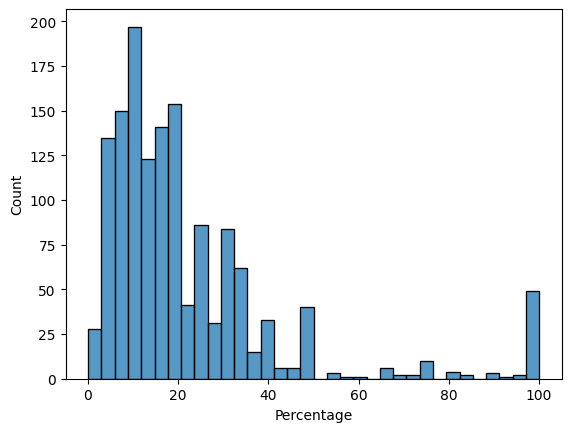

In [ ]:
# Plot histogram of layoff percentages
sns.histplot(layoff_target)

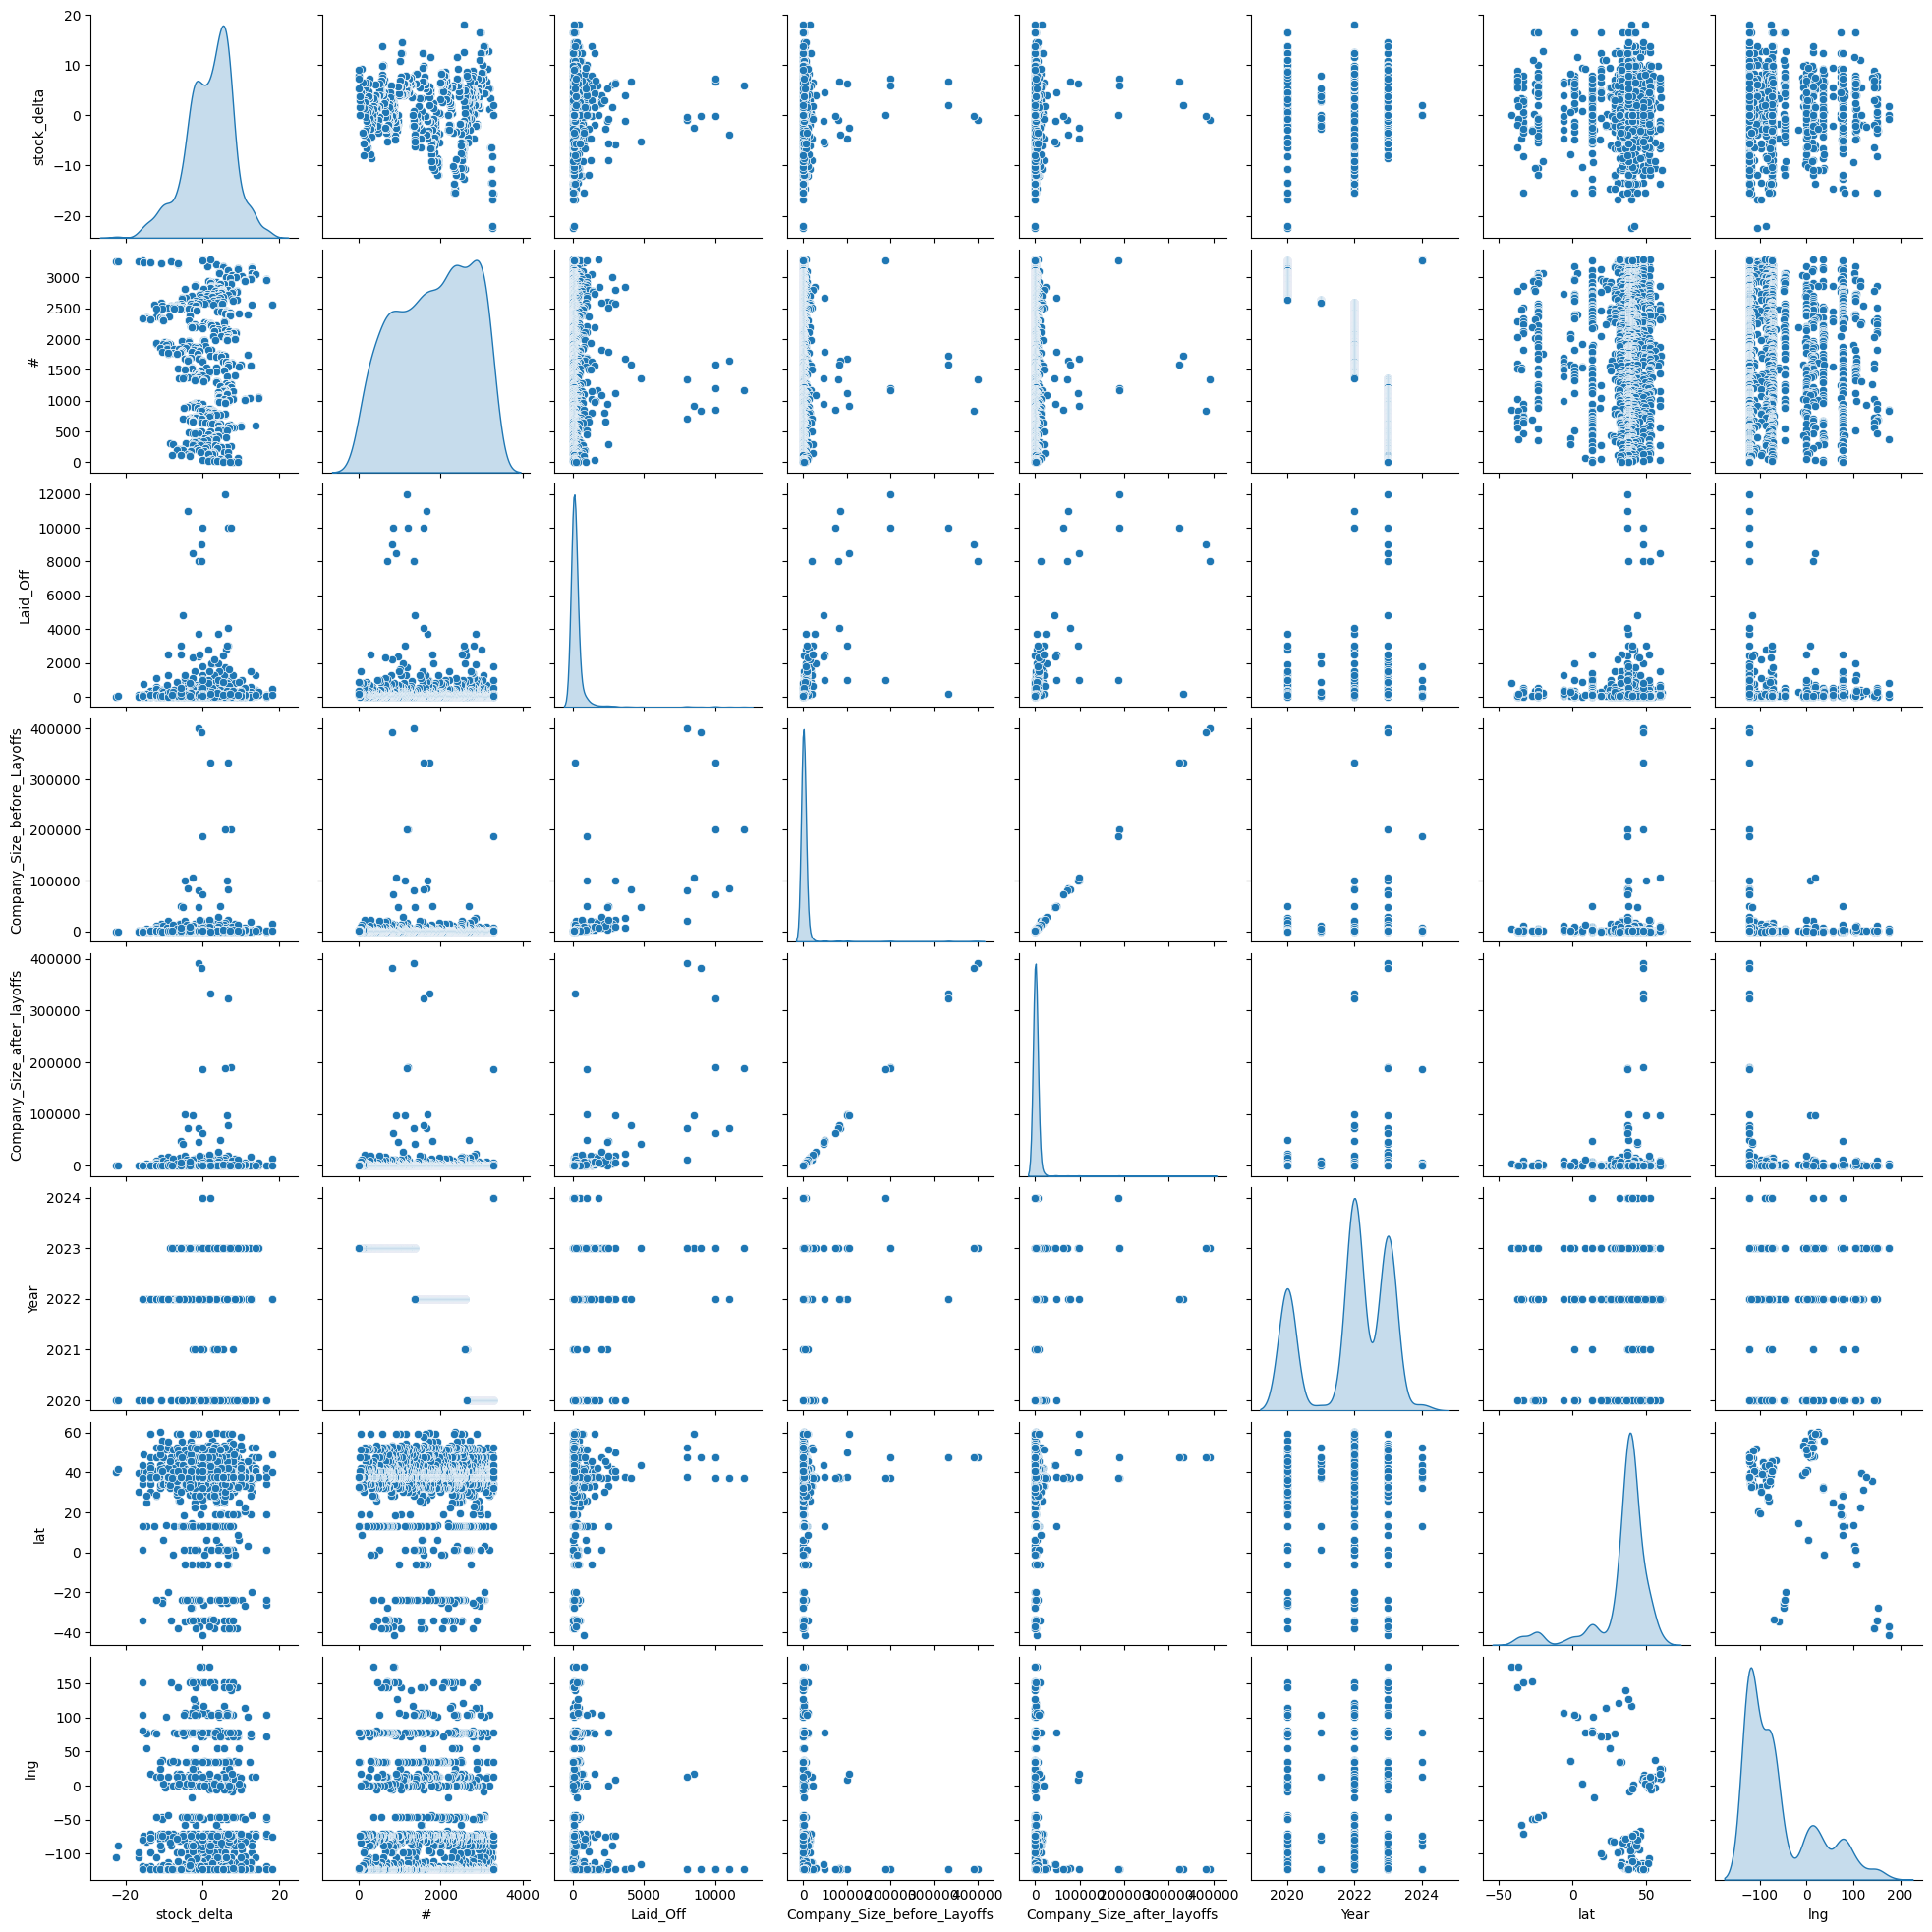

In [ ]:
# Create pairplot of features
sns.pairplot(layoff_data_with_stock, diag_kind='kde')

In [ ]:
# For American companies, let's see some insights related to total layoff counts and tech layoffs by industry.

In [ ]:
# Drop qualitative columns
dropped_cols = [
    'Company',
    'Location_HQ',
    'Country',
    'Continent',
    'Industry',
    'Stage',
]

corr_df = layoff_data_with_stock.drop(columns=dropped_cols)

In [ ]:
# Convert money to float for correlations
corr_df['Money_Raised_in_$_mil'] = corr_df['Money_Raised_in_$_mil'].replace(to_replace='[\$]', value='', regex=True).astype(float)
corr_df

,Date_layoffs,stock_delta,#,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Money_Raised_in_$_mil,Year,lat,lng
0,2020-03-12,-15.547778,3267,20,40.000000,50,30,90.0,2020,34.05223,-118.24368
1,2020-03-13,-8.133869,3266,6,75.000000,8,2,1.0,2020,37.77493,-122.41942
2,2020-03-13,-8.133869,3265,8,10.000000,80,72,45.0,2020,34.05223,-118.24368
3,2020-03-16,-16.704113,3262,130,22.000000,591,461,79.0,2020,39.73915,-104.98470
4,2020-03-16,-16.704113,3263,16,100.000000,16,0,6.0,2020,30.26715,-97.74306
...,...,...,...,...,...,...,...,...,...,...,...
1413,2024-10-01,0.000000,3279,60,13.333333,450,390,57.0,2024,37.45383,-122.18219
1414,2024-11-01,0.000000,3272,170,17.000000,1000,830,995.0,2024,37.77493,-122.41942
1415,2024-11-01,0.000000,3273,125,5.000000,2500,2375,320.0,2024,12.97194,77.59369
1416,2024-11-01,0.000000,3274,100,5.000000,2000,1900,14.0,2024,40.71427,-74.00597


In [ ]:
# Create correlation
corr = corr_df.corr()
corr

,Date_layoffs,stock_delta,#,Laid_Off,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Money_Raised_in_$_mil,Year,lat,lng
Date_layoffs,1.000000,-0.176499,-0.828164,0.055072,-0.148676,0.067856,0.067509,0.003603,0.975553,-0.008620,0.070565
stock_delta,-0.176499,1.000000,0.035223,-0.009083,-0.040935,-0.002485,-0.002188,-0.053319,-0.143815,-0.005067,-0.025192
#,-0.828164,0.035223,1.000000,-0.062037,0.129214,-0.048502,-0.047344,0.007610,-0.825867,0.011037,-0.055777
Laid_Off,0.055072,-0.009083,-0.062037,1.000000,-0.039667,0.694295,0.673233,0.135706,0.070815,0.047934,-0.052649
Percentage,-0.148676,-0.040935,0.129214,-0.039667,1.000000,-0.110175,-0.111606,-0.068719,-0.148262,-0.035883,0.097070
Company_Size_before_Layoffs,0.067856,-0.002485,-0.048502,0.694295,-0.110175,1.000000,0.999583,0.051169,0.075515,0.051019,-0.064569
Company_Size_after_layoffs,0.067509,-0.002188,-0.047344,0.673233,-0.111606,0.999583,1.000000,0.047130,0.074746,0.050496,-0.064229
Money_Raised_in_$_mil,0.003603,-0.053319,0.007610,0.135706,-0.068719,0.051169,0.047130,1.000000,0.002570,0.013211,-0.029093
Year,0.975553,-0.143815,-0.825867,0.070815,-0.148262,0.075515,0.074746,0.002570,1.000000,-0.007747,0.067282
lat,-0.008620,-0.005067,0.011037,0.047934,-0.035883,0.051019,0.050496,0.013211,-0.007747,1.000000,-0.472637


<Axes: >

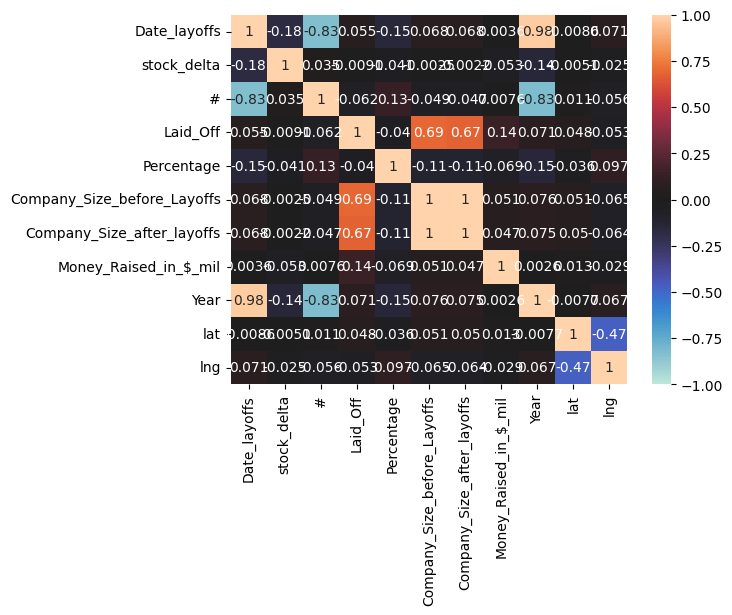

In [ ]:
# Plot correlation onto heatmap
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True)

In [ ]:
# NOTE: May want to check correlation between layoff percentage and features

In [ ]:
gdp_data = pd.read_csv('country-gdps.csv')
gdp_data

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.727850e+09,2.790850e+09,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.558906e+09,3.103184e+09,3.544708e+09
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,1.847810e+10,1.936631e+10,2.050647e+10,2.224273e+10,2.429433e+10,2.661956e+10,...,9.863429e+11,1.006992e+12,9.325135e+11,8.900514e+11,1.028394e+12,1.012521e+12,1.006191e+12,9.288802e+11,1.086531e+12,1.185138e+12
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.014642e+10,2.049713e+10,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426650e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.041165e+10,1.113592e+10,1.195171e+10,1.268581e+10,1.384900e+10,1.487476e+10,...,8.340970e+11,8.945050e+11,7.692632e+11,6.921149e+11,6.856303e+11,7.681582e+11,8.234056e+11,7.869624e+11,8.449275e+11,8.753937e+11
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.323391e+11,1.359668e+11,9.049642e+10,5.276162e+10,7.369016e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.067828e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6.735329e+09,7.074395e+09,6.295848e+09,6.682677e+09,7.180765e+09,7.878760e+09,7.899738e+09,7.717145e+09,9.412034e+09,9.409474e+09
262,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.041523e+10,4.322859e+10,4.244449e+10,3.131782e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN
263,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,8.748597e+09,9.225996e+09,9.813996e+09,1.085420e+10,1.195600e+10,1.306899e+10,...,4.008860e+11,3.811989e+11,3.467098e+11,3.235855e+11,3.814488e+11,4.052607e+11,3.893300e+11,3.382914e+11,4.201178e+11,4.052709e+11
264,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631151e+10,2.330867e+10,1.811064e+10,2.209642e+10,2.916378e+10


In [ ]:
gdp_data.isna().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2018                8
2019                8
2020                9
2021               10
2022               23
Length: 67, dtype: int64

In [ ]:
gdp_data.describe().round(2)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,1.260000e+02,1.270000e+02,1.280000e+02,1.280000e+02,1.280000e+02,1.400000e+02,1.430000e+02,1.460000e+02,1.510000e+02,1.510000e+02,...,2.590000e+02,2.600000e+02,2.580000e+02,2.580000e+02,2.580000e+02,2.580000e+02,2.580000e+02,2.570000e+02,2.560000e+02,2.430000e+02
mean,7.295339e+10,7.486095e+10,7.866324e+10,8.518005e+10,9.404305e+10,9.429468e+10,1.044708e+11,1.087439e+11,1.136923e+11,1.255383e+11,...,2.482324e+12,2.543694e+12,2.404723e+12,2.437760e+12,2.613243e+12,2.776038e+12,2.817910e+12,2.741618e+12,3.169838e+12,3.479221e+12
std,2.186744e+11,2.282797e+11,2.438626e+11,2.628174e+11,2.877300e+11,3.004628e+11,3.282242e+11,3.474790e+11,3.696235e+11,4.066424e+11,...,8.401587e+12,8.612905e+12,8.172390e+12,8.309604e+12,8.845331e+12,9.414852e+12,9.553275e+12,9.323528e+12,1.068868e+13,1.133619e+13
min,1.201202e+07,1.159202e+07,9.122751e+06,1.084010e+07,1.271247e+07,1.359393e+07,1.446908e+07,1.583511e+07,1.460000e+07,1.585000e+07,...,3.861589e+07,3.876098e+07,3.681194e+07,4.162906e+07,4.527660e+07,4.801526e+07,5.412320e+07,5.174659e+07,6.019641e+07,5.906598e+07
25%,5.151683e+08,5.111424e+08,5.185977e+08,5.150864e+08,5.415796e+08,5.199337e+08,5.894217e+08,5.190310e+08,5.605380e+08,5.988611e+08,...,8.486163e+09,9.034786e+09,8.752203e+09,8.620984e+09,9.319389e+09,1.002804e+10,1.035516e+10,9.754600e+09,1.080873e+10,1.403573e+10
50%,2.661058e+09,2.417629e+09,2.319980e+09,2.680117e+09,2.853831e+09,2.913602e+09,3.039859e+09,3.145743e+09,3.330372e+09,3.787077e+09,...,5.094967e+10,5.339986e+10,4.966767e+10,4.984325e+10,5.400009e+10,5.609719e+10,6.009099e+10,5.373453e+10,6.561177e+10,7.573231e+10
75%,2.398013e+10,2.365180e+10,2.289222e+10,2.428285e+10,2.625211e+10,2.509067e+10,2.793416e+10,2.899389e+10,3.209482e+10,3.636104e+10,...,5.390198e+11,5.478563e+11,5.020845e+11,5.057567e+11,5.369244e+11,5.524163e+11,5.419490e+11,5.470542e+11,6.501228e+11,8.912561e+11
max,1.381135e+12,1.446356e+12,1.546369e+12,1.670666e+12,1.832616e+12,1.994519e+12,2.161645e+12,2.308597e+12,2.491805e+12,2.745216e+12,...,7.771472e+13,7.983716e+13,7.528327e+13,7.651898e+13,8.148410e+13,8.654268e+13,8.777740e+13,8.525774e+13,9.752968e+13,1.013257e+14


In [ ]:
foreign_aid_data = pd.read_csv('us-foreign-aid.csv')
foreign_aid_data

,Country Code,Country Name,Region ID,Region Name,Income Group Acronym,Income Group Name,Transaction Type ID,Transaction Type Name,Fiscal Year,current_amount,constant_amount
0,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,1999,19000,31338
1,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2000,50000,80787
2,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2004,1000,1487
3,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2005,29270,42255
4,ABW,Aruba,6,Western Hemisphere,HIC,High Income Country,2,Obligations,2006,1000,1398
...,...,...,...,...,...,...,...,...,...,...,...
21549,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2019,286696401,321092817
21550,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2020,276466581,305559343
21551,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2021,314260262,336034603
21552,ZWE,Zimbabwe,5,Sub-Saharan Africa,LMIC,Lower Middle Income Country,3,Disbursements,2022,344133221,344133221


In [ ]:
foreign_aid_data.isna().sum()

Country Code               55
Country Name                0
Region ID                   0
Region Name                 0
Income Group Acronym     2384
Income Group Name        2384
Transaction Type ID         0
Transaction Type Name       0
Fiscal Year                 0
current_amount              0
constant_amount             0
dtype: int64

In [ ]:
foreign_aid_data.describe().round(2)

,Region ID,Transaction Type ID,current_amount,constant_amount
count,21554.00,21554.00,2.155400e+04,2.155400e+04
mean,3.85,4.02,1.768907e+08,2.835380e+08
std,1.82,5.18,9.854787e+08,1.321976e+09
min,1.00,1.00,-6.382327e+07,-4.976816e+08
25%,2.00,2.00,1.700000e+06,3.102825e+06
50%,5.00,2.00,1.759600e+07,3.056596e+07
75%,5.00,3.00,7.916878e+07,1.291599e+08
max,7.00,18.00,2.594584e+10,4.085656e+10


# Comprehensive Analysis of Relevant Data 

In [16]:
# process data
import seaborn as sns
layoff_data = pd.read_csv("tech_layoffs.csv")
from sklearn.preprocessing import LabelEncoder

layoff_data['Money_Raised_in_$_mil'] = layoff_data['Money_Raised_in_$_mil'].str.replace('$', '').astype(float)
MoneyRaised = layoff_data['Money_Raised_in_$_mil']

unique_industries = layoff_data['Industry'].unique()
label_encoder = LabelEncoder()
layoff_data['Industry_encoded'] = label_encoder.fit_transform(layoff_data['Industry'])
Industry = layoff_data['Industry_encoded']

sizebeforelayoff = layoff_data['Company_Size_after_layoffs']
sizeafterlayoff = layoff_data['Company_Size_after_layoffs']

unique_stage = layoff_data['Stage'].unique()
label_encoder = LabelEncoder()
layoff_data['Stage_encoded'] = label_encoder.fit_transform(layoff_data['Stage'])
Stage = layoff_data['Stage_encoded']
Percentage = layoff_data['Percentage']

data = { 
        
        'MoneyRaised' : MoneyRaised,
        'SizeBeforeLayoff':sizebeforelayoff,
        'SizeAfterLayoff':sizeafterlayoff,
        'Percentage':Percentage

        }



# CORRELATION MATRIX TO HELP ANSWER THE FOLLOWING QUESTIONS:

  -> Would a company have more layoffs if its company size was relatively big before the layoff? </br>

 -> Does the size of the company after a layoff be indicative of how big the layoff was? </br>

 -> If a company has more money raised, then would the size of their layoff be smaller? 


In [17]:
df = pd.DataFrame(data)
# Calculate the correlation matrix
correlation_matrix = df.corr()

correlation_with_percentage = correlation_matrix['Percentage']

sorted_correlation = correlation_with_percentage.abs().sort_values(ascending=False)

print(sorted_correlation)

Percentage          1.000000
SizeBeforeLayoff    0.111606
SizeAfterLayoff     0.111606
MoneyRaised         0.068719
Name: Percentage, dtype: float64


# ANALYSIS ON INDUSTRY AND STAGE OF THE COMPANIES WHO HAD MASSIVE LAYOFF. HELP ANSWER THE FOLLOWING QUESTIONS:

-> Are certain industries more prone to experiencing layoffs compared to others? </br>

-> Does the current stage of a company serve as a significant indicator of the likelihood of layoffs? </br>

In [18]:
industry_counts = layoff_data['Industry'].value_counts()
# Get the top 5 industries
top_5_industries = industry_counts.head(5)
# Display the result
print(top_5_industries)

Industry
Finance           200
Retail            117
Healthcare        104
Transportation     92
Food               90
Name: count, dtype: int64


In [19]:
stage_counts = layoff_data['Stage'].value_counts()

# Get the top 5 stages
top_5_stages = stage_counts.head(5)

# Display the result
print(top_5_stages)

Stage
Post-IPO    312
Series B    195
Series C    175
Unknown     173
Series D    158
Name: count, dtype: int64
